In [1]:
# Including libraries 
options( warn = -1 )
library(dplyr)
library(tidyr)
library(stringr)
library(geohash)

library(ggplot2)
library(ggmap)
library(maps)
library(maptools)
library(sqldf)
library(party)
library(randomForest)
library(MASS)
library("survival")
library("xgboost")



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich

Attaching package: ‘strucchange’

The following object is masked from ‘package:stringr’:


In [2]:
# Download data from the links provided
library(downloader)
# Blight Violations
dbvurl <- "https://d18ky98rnyall9.cloudfront.net/_97bd1c1e5df9537bb13398c9898deed7_detroit-blight-violations.csv?Expires=1487808000&Signature=gHUOfvUDTW-h~HuT0YXBeapK~jrxVV~G~ItLJCGvxfndaU-ZnP0OI1lurvBMMbxRy3JymGjsyrfMZvY8uXkywWwOeRT3JzfyXftxHVbDpw6rRsfOgmR0Bwu6HHIbcSSANPjFG9p6FwpQh1YyJUKvMj8IQCoaanPuG10SRLWg7Bc_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DBVFileName <- "detroit-blight-violations.csv"
if (!file.exists(DBVFileName)) 
    download(dbvurl, DBVFileName)
detBlightViol <- read.csv("detroit-blight-violations.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )   
    
# Detroit Demolition Permits 
ddpurl <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-demolition-permits.tsv?Expires=1487808000&Signature=GIkiK8yRf70Fya8VNatb9t~lXh5VD4kX05GZMKlqb3l2lX-z9aXk4okJQao6dOfApCcdgM~-6L3KlBG1YKhFbCKQqagI2ALjFt-PTkJeCyfPFSQ5FqMcQlh7qUClpZCH7F~zJA9X-vutv6IIaS-tKt22sAGgwu9X6lCtw6raPBo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DDPFileName <- "detroit-demolition-permits.tsv"
if (!file.exists(DDPFileName)) 
    download(ddpurl, DDPFileName)
detDemolitionPermit <- read.delim("detroit-demolition-permits.tsv", header=TRUE, allowEscapes=FALSE, sep="\t", na.strings="", comment.char="")

    
# Detroit 311 calls
d311url <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-311.csv?Expires=1487808000&Signature=PTTniMA9xRitX6DycZSOORb45gCHgqeHDQABaMn54N6CswNJmFIXEYolvrWNCXlp~K4gn9zaSUOm27eQJhmEg4n7FUTJ5ZrWnVWBOfFRxouPgcglrdqUHfx-HKqnTMByfTLcEPmEqhZLKg7d9SLYsx4Cc2vwxCFshMjhpEF7ZwA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
D311FileName <- "detroit-311.csv"
if (!file.exists(D311FileName)) 
    download(d311url, D311FileName)
det311 <- read.csv("detroit-311.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )  

# Detroit Crime 
dcrurl <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-crime.csv?Expires=1487808000&Signature=POU~pk3A00i-iFJpAT9ytnBpfygEdMrPcITocHFPPHbyHegki~dcECrUD1kWApMOYmymWt2Vrm5c5mWmKG1pwpIaMPLwFGkF5kUkMTgCLuask2b0LnKcDOI86WzRYmkBsN2VvSQxXNK9y8CvCs2pUVzmwYbwGwstsOqbZei-Ohg_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DCRFileName <- "detroit-crime.csv"
if (!file.exists(DCRFileName)) 
    download(dcrurl, DCRFileName)
detCrime <- read.csv("detroit-crime.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )    
       

In [3]:
#dplyr mutate to extract (LAT,LNG) from ViolationAddress. 
detBlightViol <- detBlightViol %>%
    #filter(TicketIssuedDT > "2005-01-01" & TicketIssuedDT <"2018-01-01") %>%
    mutate(latlng = gsub(".*\\n", "", ViolationAddress)) %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    filter(latlng != 'character(0)') %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    separate(latlng, c('LAT', 'LNG'), ', ')

#dplyr mutate to extract (LAT,LNG) from site_location
detDemolitionPermit <- detDemolitionPermit %>%
    mutate(latlng = gsub(".*\\n", "", site_location)) %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    filter(latlng != 'character(0)') %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    separate(latlng, c('LAT', 'LNG'), ', ')


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Detroit&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Detroit&sensor=false


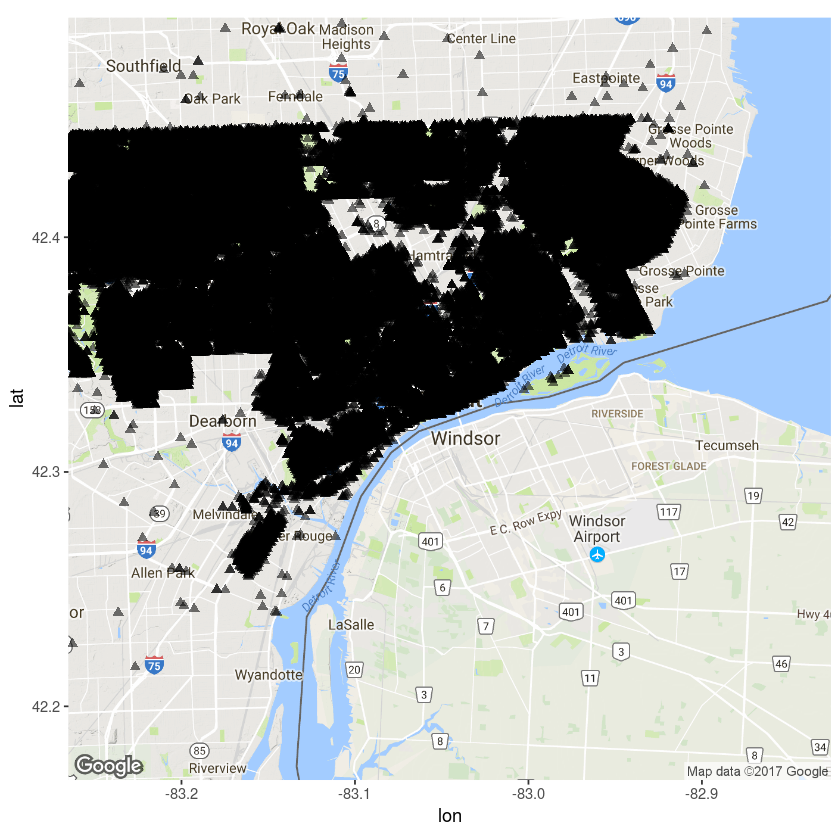

In [4]:
#Visualize to glance through the data
#library(ggplot2)
#library(ggmap)
#library(maps)
#library(maptools)

# get Google map to plot the data into it
detroit_map <- get_map(location = "Detroit", zoom = 11,
                      maptype = "t", scale = 2)
#Crime incidents
ggmap(detroit_map) +
  geom_point(data = detCrime, aes(x = detCrime$LON, y = detCrime$LAT, fill = "red", alpha = 0.8), size = 2, shape = 17) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

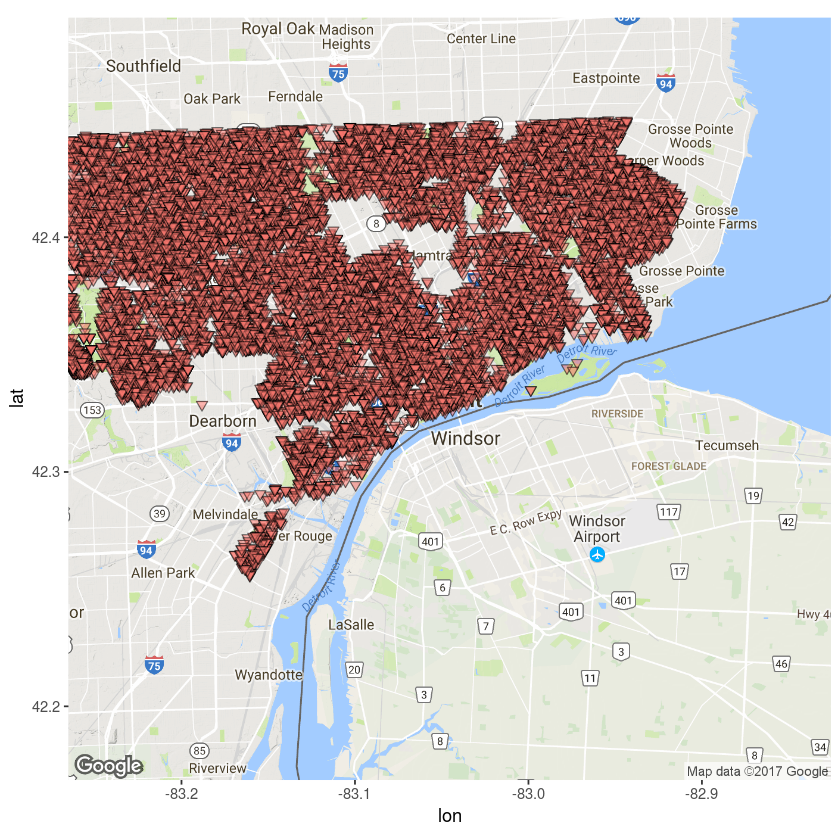

In [5]:
#311 Calls
ggmap(detroit_map) +
  geom_point(data = det311, aes(x = det311$lng, y = det311$lat, fill = "green", alpha = 0.8), size = 2, shape = 25) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

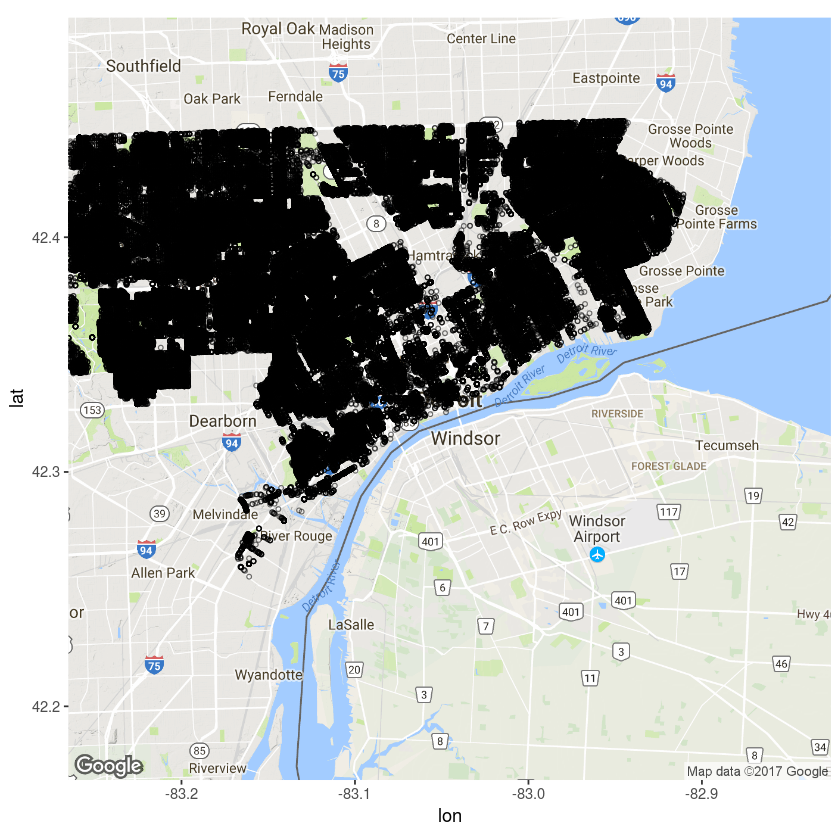

In [6]:
#Blight Violation
blight_viols <- detBlightViol %>%
  transform(LNG = as.numeric(LNG),
            LAT = as.numeric(LAT))

ggmap(detroit_map) +
  geom_point(data = blight_viols, aes(x = blight_viols$LNG, y = blight_viols$LAT, alpha = 0.1), size = 1, shape = 1) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

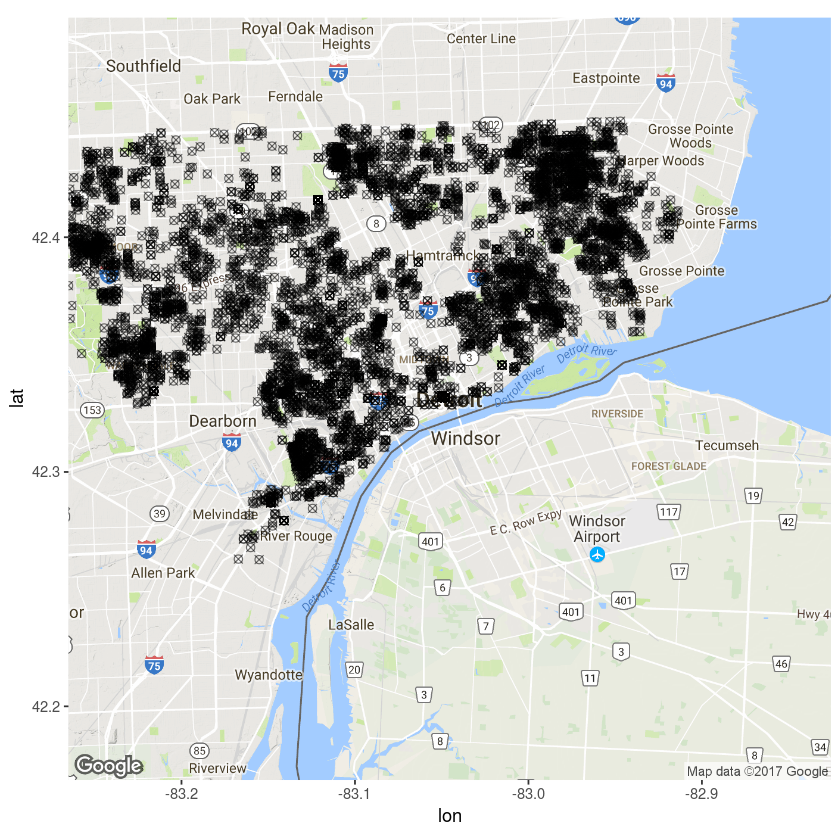

In [7]:
#Demolition permits
demo_permits <- detDemolitionPermit %>%
  transform(LNG = as.numeric(LNG),
            LAT = as.numeric(LAT))
ggmap(detroit_map) +
  geom_point(data = demo_permits, aes(x = LNG, y = LAT, fill = "yellow", alpha = 0.8), size = 2, shape = 13) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

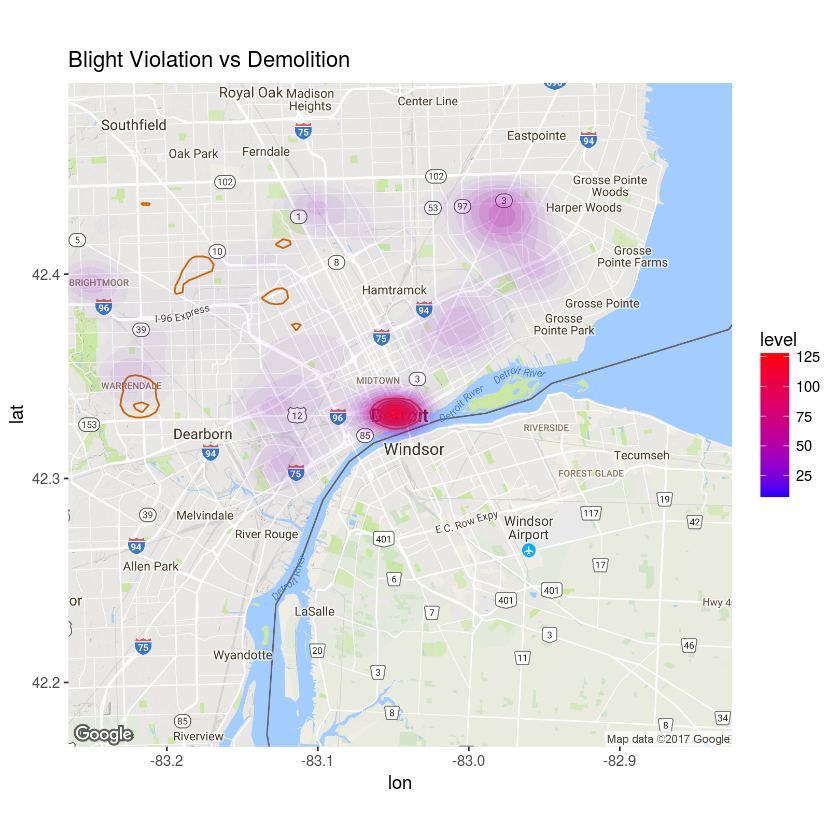

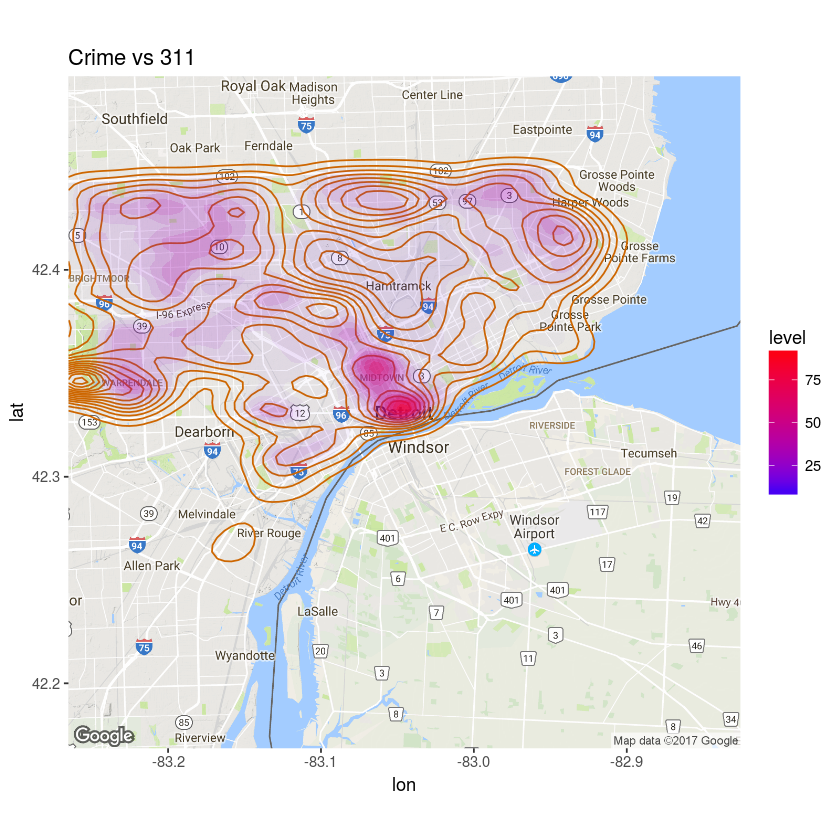

In [8]:
#Plot Blight violations with Demolition permits
ggmap(detroit_map) + 
  stat_density2d(data=blight_viols, aes(x=blight_viols$LNG, y=blight_viols$LAT), size = 0.5, color="darkorange3") + 
  stat_density2d(data=demo_permits, aes(x=demo_permits$LNG, y=demo_permits$LAT, fill = ..level.., alpha = ..level..), size = 0.01, bins = 16, geom = "polygon") + 
  scale_fill_gradient(low = "blue", high = "red") + 
  scale_alpha(range = c(0, 0.3), guide = FALSE) + labs(title="Blight Violation vs Demolition")

#Plot Crimes with 311 calls
ggmap(detroit_map) +
  stat_density2d(data=det311, aes(x=det311$lng, y=det311$lat), size = 0.5, color="darkorange3") + 
  stat_density2d(data=detCrime, aes(x=detCrime$LON, y=detCrime$LAT, fill = ..level.., alpha = ..level..), size = 0.01, bins = 16, geom = "polygon") + 
  scale_fill_gradient(low = "blue", high = "red") + 
  scale_alpha(range = c(0, 0.3), guide = FALSE) + labs(title="Crime vs 311")


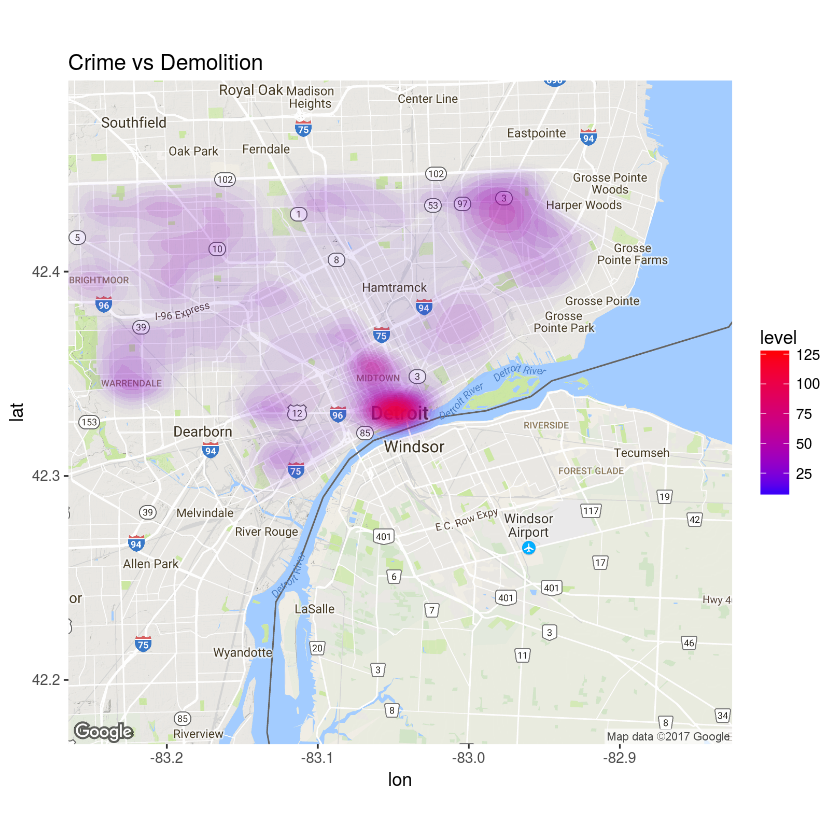

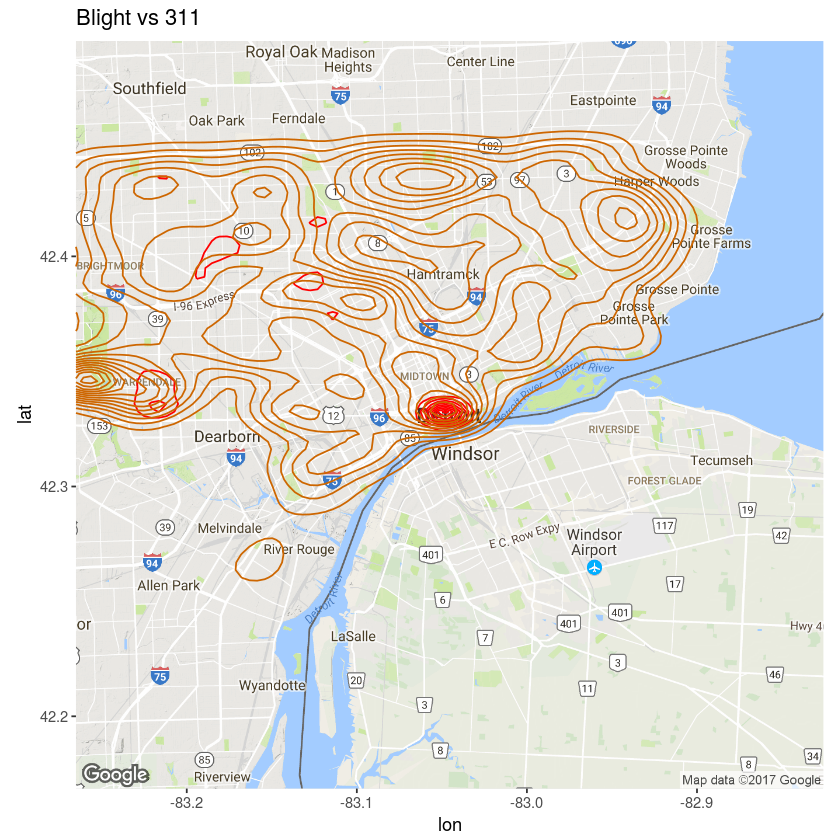

In [9]:
#Crime vs Demolition
ggmap(detroit_map) +
  stat_density2d(data=detCrime, aes(x=detCrime$LON, y=detCrime$LAT, fill = ..level.., alpha = ..level..), size = 0.01, bins = 16, geom = "polygon") + 
  stat_density2d(data=demo_permits, aes(x=demo_permits$LNG, y=demo_permits$LAT, fill = ..level.., alpha = ..level..), size = 0.01, bins = 16, geom = "polygon") + 
  scale_fill_gradient(low = "blue", high = "red") + 
  scale_alpha(range = c(0, 0.3), guide = FALSE) + labs(title="Crime vs Demolition")

#Blight vs 311
ggmap(detroit_map) +
  stat_density2d(data=blight_viols, aes(x=blight_viols$LNG, y=blight_viols$LAT), size = 0.5, color="red") + 
  stat_density2d(data=det311, aes(x=det311$lng, y=det311$lat), size = 0.5, color="darkorange3") + 
  scale_fill_gradient(low = "blue", high = "red") + 
  scale_alpha(range = c(0, 0.3), guide = FALSE) + labs(title="Blight vs 311")

In [10]:
#dplyr filter to create gh_8 uid colums 
detBlightViol <- detBlightViol %>%    
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LNG), 8),
           uid = paste0('blightviol_',row_number()))

detDemolitionPermit <- detDemolitionPermit %>%
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LNG), 8),
           uid = paste0('demolper',row_number()))

det311 <- det311 %>%
    mutate(gh_8 = gh_encode(as.numeric(lat), as.numeric(lng), 8),
           uid = paste0('det311',row_number()))

detCrime <- detCrime %>%
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LON), 8),
           uid = paste0('detcrim',row_number()))

In [11]:
#Summarize records based on gh_8
dbv_gh_8_grp <- detBlightViol %>%
    group_by(gh_8) %>%
    summarize(dbv_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(dbv_ngbr_8_ct))

ddp_gh_8_grp <- detDemolitionPermit %>%    
    group_by(gh_8) %>%
    summarize(ddp_ngbr_8_ct = n()) %>% 
    arrange(gh_8,desc(ddp_ngbr_8_ct))

#Summarize dates for survival analysis
ddp_gh_8_grp_d <- detDemolitionPermit %>%    
    group_by(gh_8) %>%
    summarize(M_PERMIT_ISSUED=mean(as.numeric(PERMIT_ISSUED,format='%m/%d/%Y'), na.rm=TRUE)) 

d311_gh_8_grp <- det311 %>%
    group_by(gh_8) %>%
    summarize(d311_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(d311_ngbr_8_ct))

dcr_gh_8_grp <- detCrime %>%
    group_by(gh_8) %>%
    summarize(dcr_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(dcr_ngbr_8_ct))


In [12]:
#join counts and demolished dates based on gh_8
detBlightViolV <- left_join(detBlightViol, dbv_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVD <- left_join(detBlightViolV, ddp_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVDD <- left_join(detBlightViolVD, ddp_gh_8_grp_d, by = c("gh_8" = "gh_8"))
detBlightViolVD3 <- left_join(detBlightViolVDD, d311_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVD3C <- left_join(detBlightViolVD3, dcr_gh_8_grp, by = c("gh_8" = "gh_8"))


In [13]:
#Keeping only the colums required for analysis
keep <- c("LAT","LNG","gh_8",  "dbv_ngbr_8_ct", "ddp_ngbr_8_ct", "d311_ngbr_8_ct", "dcr_ngbr_8_ct",  "ViolationCategory", "CleanUpCost", "JudgmentAmt", "PaymentStatus", "FineAmt", "AdminFee", "LateFee", "AgencyName", "TicketIssuedDT", "M_PERMIT_ISSUED")
detBlightViolVD3C <- detBlightViolVD3C[keep]

# Assing values
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="PAID IN FULL"] <- 1
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="PARTIAL PAYMENT MADE"] <- 2
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="NO PAYMENT APPLIED"] <- 3
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="NO PAYMENT ON RECORD"] <- 4

detBlightViolVD3C$PaymentStatus <- as.numeric(detBlightViolVD3C$PaymentStatus)

detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Department of Public Works"] <- 1
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Building and Safety Engineering Department"] <- 2
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Health Department"] <- 3
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Detroit Police Department"] <- 4

#Data Cleanup
detBlightViolVD3C$AgencyName[is.na(detBlightViolVD3C$AgencyName)] <- as.numeric(0)
detBlightViolVD3C$AgencyName <- as.numeric(detBlightViolVD3C$AgencyName)
detBlightViolVD3C$AgencyName[is.na(detBlightViolVD3C$AgencyName)] <- as.numeric(0)

In [14]:
# Data preparation to avoid non-numerics from the dataset
ifelse ((!is.na(detBlightViolVD3C$CleanUpCost) || detBlightViolVD3C$CleanUpCost != ""),
    detBlightViolVD3C$CleanUpCost <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$CleanUpCost)))),
    detBlightViolVD3C$CleanUpCost <- as.numeric(0))
    
ifelse ((!is.na(detBlightViolVD3C$JudgmentAmt) || detBlightViolVD3C$JudgmentAmt != ""),
    detBlightViolVD3C$JudgmentAmt <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$JudgmentAmt)))),
    detBlightViolVD3C$JudgmentAmt <- as.numeric(0))
detBlightViolVD3C$JudgmentAmt[is.na(detBlightViolVD3C$JudgmentAmt)] <- as.numeric(0)

ifelse ((!is.na(detBlightViolVD3C$FineAmt) || detBlightViolVD3C$FineAmt != ""),
    detBlightViolVD3C$FineAmt <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$FineAmt)))),
    detBlightViolVD3C$FineAmt <- as.numeric(0))
detBlightViolVD3C$FineAmt[is.na(detBlightViolVD3C$FineAmt)] <- as.numeric(0)

ifelse ((!is.na(detBlightViolVD3C$AdminFee) || detBlightViolVD3C$AdminFee != ""),
    detBlightViolVD3C$AdminFee <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$AdminFee)))),
    detBlightViolVD3C$AdminFee <- as.numeric(0))

ifelse ((!is.na(detBlightViolVD3C$LateFee) || detBlightViolVD3C$LateFee != ""),
    detBlightViolVD3C$LateFee <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$LateFee)))),
    detBlightViolVD3C$LateFee <- as.numeric(0))

detBlightViolVD3C$ddp_ngbr_8_ct[is.na(detBlightViolVD3C$ddp_ngbr_8_ct)] <- as.numeric(0)
detBlightViolVD3C$d311_ngbr_8_ct[is.na(detBlightViolVD3C$d311_ngbr_8_ct)] <- as.numeric(0)
detBlightViolVD3C$dcr_ngbr_8_ct[is.na(detBlightViolVD3C$dcr_ngbr_8_ct)] <- as.numeric(0)

detBlightViolVD3C$Demolished[detBlightViolVD3C$ddp_ngbr_8_ct >0 ] <- 1
detBlightViolVD3C$Demolished[detBlightViolVD3C$ddp_ngbr_8_ct <=0 ] <- 0

ifelse ((!is.na(detBlightViolVD3C$TicketIssuedDT) || detBlightViolVD3C$TicketIssuedDT != ""),
        detBlightViolVD3C$TicketIssuedDT <- as.numeric(as.Date(detBlightViolVD3C$TicketIssuedDT,"%m/%d/%Y %H:%M:%S")),
        detBlightViolVD3C$TicketIssuedDT <- as.numeric(0))

ifelse ((!is.na(detBlightViolVD3C$M_PERMIT_ISSUED) || detBlightViolVD3C$M_PERMIT_ISSUED != ""),
        detBlightViolVD3C$M_PERMIT_ISSUED <- as.numeric(detBlightViolVD3C$M_PERMIT_ISSUED),
        detBlightViolVD3C$M_PERMIT_ISSUED <- as.numeric(0))        

nrow(detBlightViolVD3C)
summary(detBlightViolVD3C)


[1] 0

[1] 1680

[1] 1500

[1] 20

[1] 150

[1] NA

[1] NA

[1] 307804

     LAT                LNG                gh_8           dbv_ngbr_8_ct  
 Length:307804      Length:307804      Length:307804      Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    4  
 Mode  :character   Mode  :character   Mode  :character   Median :    7  
                                                          Mean   : 1562  
                                                          3rd Qu.:   14  
                                                          Max.   :21114  
                                                                         
 ddp_ngbr_8_ct    d311_ngbr_8_ct    dcr_ngbr_8_ct     ViolationCategory 
 Min.   :  0.00   Min.   : 0.0000   Min.   : 0.0000   Min.   :0.000000  
 1st Qu.:  0.00   1st Qu.: 0.0000   1st Qu.: 0.0000   1st Qu.:0.000000  
 Median :  0.00   Median : 0.0000   Median : 0.0000   Median :0.000000  
 Mean   : 38.37   Mean   : 0.0419   Mean   : 0.8085   Mean   :0.006553  
 3rd Qu.:  0.00   3rd Qu.: 0.0000   3rd Qu.

In [15]:
#Summarize based on gh_8
detBlightViolVD3C <- detBlightViolVD3C %>%
      group_by(gh_8) %>%
      summarize(m_dbv_ngbr_8_ct=mean(dbv_ngbr_8_ct, na.rm=TRUE), 
                m_ddp_ngbr_8_ct=mean(ddp_ngbr_8_ct, na.rm=TRUE),
                m_d311_ngbr_8_ct=mean(d311_ngbr_8_ct, na.rm=TRUE),
                m_dcr_ngbr_8_ct=mean(dcr_ngbr_8_ct, na.rm=TRUE),
                m_ViolationCategory=max(ViolationCategory, na.rm=TRUE),
                s_CleanUpCost=sum(CleanUpCost, na.rm=TRUE),
                s_JudgmentAmt=sum(JudgmentAmt, na.rm=TRUE),
                m_PaymentStatus=mean(PaymentStatus, na.rm=TRUE),
                s_FineAmt=sum(FineAmt, na.rm=TRUE),
                s_LateFee=sum(LateFee, na.rm=TRUE),
                m_AgencyName=max(AgencyName, na.rm=TRUE),
                m_Demolished=max(Demolished, na.rm=TRUE),
                m_TicketIssuedDT= min(TicketIssuedDT,na.rm=TRUE ),
                M_M_PERMIT_ISSUED=min(M_PERMIT_ISSUED,na.rm=TRUE))


In [16]:
# Using SQL queries on dataset to understand data.
#library(sqldf)
sqldf("select count(*) from 'detBlightViolVD3C' where m_Demolished=1")

Loading required package: tcltk


count(*)
1 3142

In [17]:
# Training and test data
indexes = sample(nrow(detBlightViolVD3C), size=0.1*nrow(detBlightViolVD3C))
train = detBlightViolVD3C[indexes,]
test = detBlightViolVD3C[-indexes,]

In [18]:
# Formula 
fol <- formula(m_Demolished ~ m_dbv_ngbr_8_ct + m_ddp_ngbr_8_ct + m_d311_ngbr_8_ct  + m_dcr_ngbr_8_ct +
                s_CleanUpCost + s_JudgmentAmt + m_PaymentStatus +
                s_FineAmt + s_LateFee + m_AgencyName )

In [19]:
#Random forest model analysis
#library(party)
#library(randomForest)

rfModel <- randomForest(fol, data=train, na.action = na.omit)
print(rfModel)
rfPred <- predict(rfModel, newdata = test, na.action = na.omit)
summary(rfPred)
rfTbl <- table(rfPred, test$m_Demolished)



Call:
 randomForest(formula = fol, data = train, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 9.429796e-05
                    % Var explained: 99.79


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0001875 0.0459300 0.0009420 1.0000000 

In [20]:
head(rfTbl)

                       
rfPred                  0 1
  -1.17475473793149e-16 1 0
  -1.16878728917413e-16 1 0
  -1.16129328375791e-16 1 0
  -1.15227272168283e-16 1 0
  -1.15019105351166e-16 1 0
  -1.14935838624319e-16 1 0


	Pearson's Chi-squared test

data:  as.numeric(test$m_Demolished) and test$m_ddp_ngbr_8_ct
X-squared = 61177, df = 13, p-value < 2.2e-16



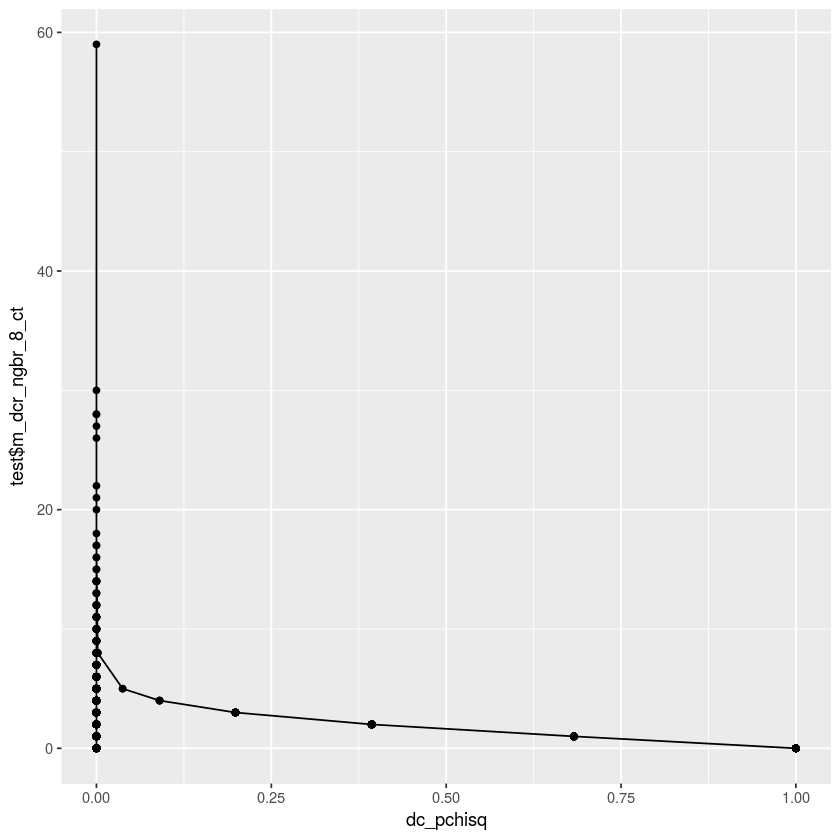

In [21]:
#chi-squre analysis
#library(MASS)
print(chisq.test(as.numeric(test$m_Demolished), test$m_ddp_ngbr_8_ct))
#pchisq gives the distribution function - applying demolished with crime counts.
dc_pchisq<-(pchisq (as.numeric(test$m_Demolished), as.numeric(test$m_dcr_ngbr_8_ct)) )
#dchisq gives the density function - applying demolished with crime counts.
dc_dchisq<-head(dchisq (as.numeric(test$m_Demolished), as.numeric(test$m_dcr_ngbr_8_ct)) )
#rchisq gives the random distribution - applying demolished with crime counts.
dc_rchisq<-head(rchisq (as.numeric(test$m_Demolished), as.numeric(test$m_dcr_ngbr_8_ct)) )

ggplot(test, aes(x=dc_pchisq, y=test$m_dcr_ngbr_8_ct)) +geom_point() + geom_line(data=test, aes(x=dc_pchisq))


Call: survfit(formula = Surv(test$m_TicketIssuedDT, test$m_Demolished == 
    0) ~ 0)

   4490 observations deleted due to missingness 
      n  events  median 0.95LCL 0.95UCL 
  56687   53996   13906   13895   13913 


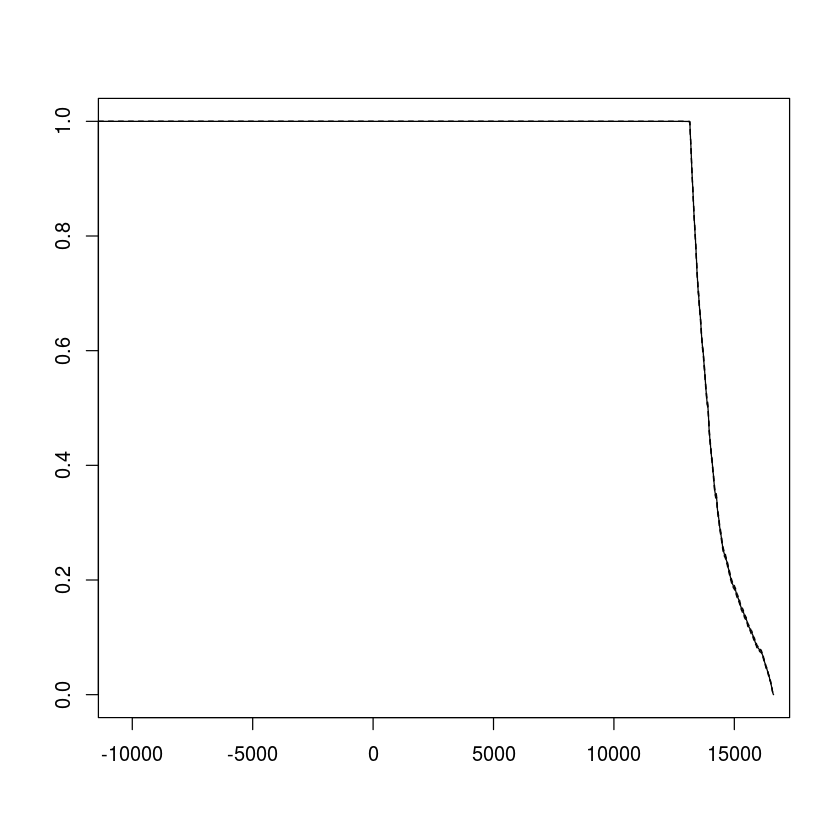

In [22]:
#library("survival")

sfit<-survfit(Surv(test$m_TicketIssuedDT,test$m_Demolished == 0)~0)
print(sfit)
plot(sfit)

In [23]:
#library("xgboost")

xKeep <- c( "m_dbv_ngbr_8_ct","m_ddp_ngbr_8_ct","m_d311_ngbr_8_ct","m_ViolationCategory","s_LateFee","s_FineAmt","s_JudgmentAmt","s_CleanUpCost",
           "m_PaymentStatus","m_AgencyName","m_Demolished")
xtrain <- train[xKeep]
xtest <- test[xKeep]

trainMatrix <- as.matrix(xtrain)
testMatrix <- as.matrix(xtest)

xgb <- xgboost(data = data.matrix(xtrain[,-1]), 
 label =xtrain$m_Demolished , 
 eta = 0.1,
 max_depth = 15, 
 nround=10, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "mlogloss",
 objective = "multi:softprob",
 num_class = 100,
 nthread = 2
)

[1]	train-mlogloss:0.703143 
[2]	train-mlogloss:0.519274 
[3]	train-mlogloss:0.469604 
[4]	train-mlogloss:0.422031 
[5]	train-mlogloss:0.382672 
[6]	train-mlogloss:0.344938 
[7]	train-mlogloss:0.313430 
[8]	train-mlogloss:0.283158 
[9]	train-mlogloss:0.256051 
[10]	train-mlogloss:0.231721 


[1] 61177    11

  [1] 0.011749922 0.322713614 0.006791076 0.006791250 0.006791760 0.006791186
  [7] 0.006791689 0.006790740 0.006791363 0.006790991 0.006790742 0.006791425
 [13] 0.006790936 0.006791522 0.006791909 0.006790833 0.006791882 0.006791784
 [19] 0.006791726 0.006789851 0.006790983 0.006791260 0.006790627 0.006790677
 [25] 0.006791504 0.006791064 0.006790792 0.006791599 0.006792084 0.006790368
 [31] 0.006791237 0.006790382 0.006791496 0.006791600 0.006791219 0.006791885
 [37] 0.006791312 0.006791688 0.006790614 0.006790841 0.006791578 0.006790859
 [43] 0.006790136 0.006789890 0.006791247 0.006791498 0.006790860 0.006792641
 [49] 0.006791380 0.006790721 0.006790672 0.006791427 0.006792202 0.006791545
 [55] 0.006791810 0.006790854 0.006791770 0.006791137 0.006790500 0.006790119
 [61] 0.006792034 0.006791091 0.006790274 0.006792122 0.006790975 0.006790483
 [67] 0.006790371 0.006792646 0.006791959 0.006789722 0.006790488 0.006791056
 [73] 0.006791241 0.006792131 0.006790057 0.006791778 0.00679187

##### xgb.Booster
raw: 186 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, eta = 0.1, max_depth = 15, subsample = 0.5, 
    colsample_bytree = 0.5, seed = 1, eval_metric = "mlogloss", 
    objective = "multi:softprob", num_class = 100, nthread = 2)
params (as set within xgb.train):
  eta = "0.1", max_depth = "15", subsample = "0.5", colsample_bytree = "0.5", seed = "1", eval_metric = "mlogloss", objective = "multi:softprob", num_class = "100", nthread = "2", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
  cb.save.model(save_period = save_period, save_name = save_name)
niter: 10
evaluation_log:
    iter train_mlogloss
       1       0.703143

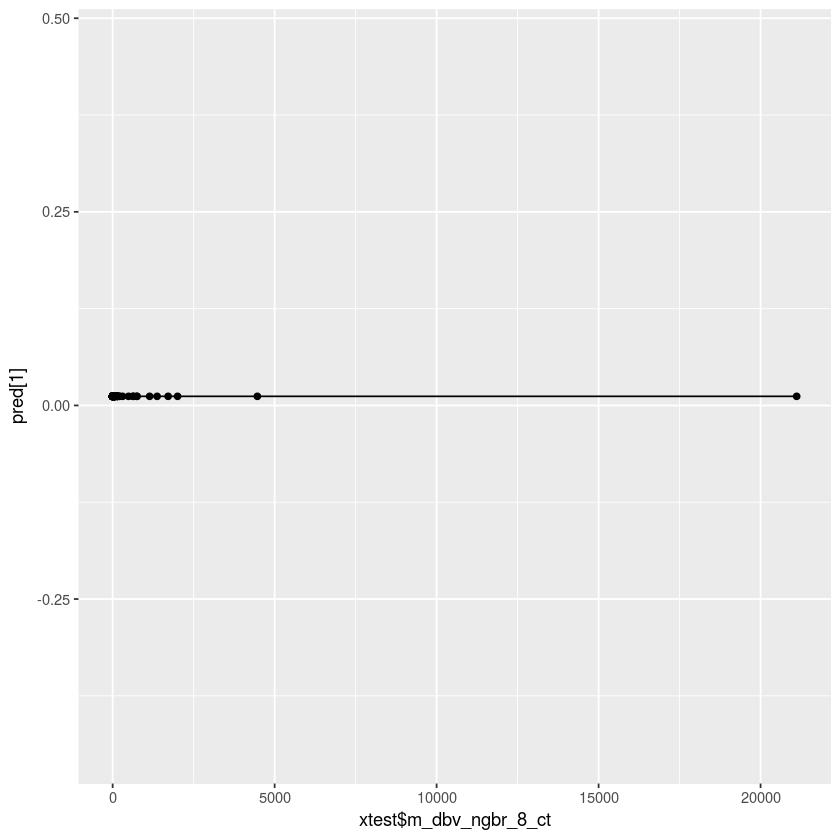

In [24]:
dim(xtest)
pred <- predict(xgb, t(xtest[1,7]))

print(pred)
ggplot(xtest, aes(x=xtest$m_dbv_ngbr_8_ct, y=pred[1])) +geom_point() + geom_line(data=xtest, aes(y=pred[1]))
print(xgb)

In [25]:
model <- xgb.dump(xgb, with.stats = T)
model[1:10]
print(model)

[1] "booster[0]"                                                    
 [2] "0:[f0<0.5] yes=1,no=2,missing=1,gain=7126.2,cover=68.3892"     
 [3] "1:leaf=4.92468,cover=65.3796"                                  
 [4] "2:leaf=-0.037909,cover=3.0096"                                 
 [5] "booster[1]"                                                    
 [6] "0:[f4<775] yes=1,no=2,missing=1,gain=26.0986,cover=67.6764"    
 [7] "1:[f7<3.1] yes=3,no=4,missing=3,gain=5.98319,cover=37.1448"    
 [8] "3:[f1<0.5] yes=7,no=8,missing=7,gain=3.73927,cover=35.046"     
 [9] "7:[f4<275] yes=11,no=12,missing=11,gain=3.09546,cover=33.8382" 
[10] "11:[f3<7.5] yes=15,no=16,missing=15,gain=4.61453,cover=18.0576"

   [1] "booster[0]"                                                        
   [2] "0:[f0<0.5] yes=1,no=2,missing=1,gain=7126.2,cover=68.3892"         
   [3] "1:leaf=4.92468,cover=65.3796"                                      
   [4] "2:leaf=-0.037909,cover=3.0096"                                     
   [5] "booster[1]"                                                        
   [6] "0:[f4<775] yes=1,no=2,missing=1,gain=26.0986,cover=67.6764"        
   [7] "1:[f7<3.1] yes=3,no=4,missing=3,gain=5.98319,cover=37.1448"        
   [8] "3:[f1<0.5] yes=7,no=8,missing=7,gain=3.73927,cover=35.046"         
   [9] "7:[f4<275] yes=11,no=12,missing=11,gain=3.09546,cover=33.8382"     
  [10] "11:[f3<7.5] yes=15,no=16,missing=15,gain=4.61453,cover=18.0576"    
  [11] "15:leaf=0.179614,cover=3.9996"                                     
  [12] "16:[f4<140] yes=21,no=22,missing=21,gain=1.35574,cover=14.058"     
  [13] "21:[f7<1.5] yes=27,no=28,missing=27,gain=0.676184,cover=4.653"     
  [14] "27:l

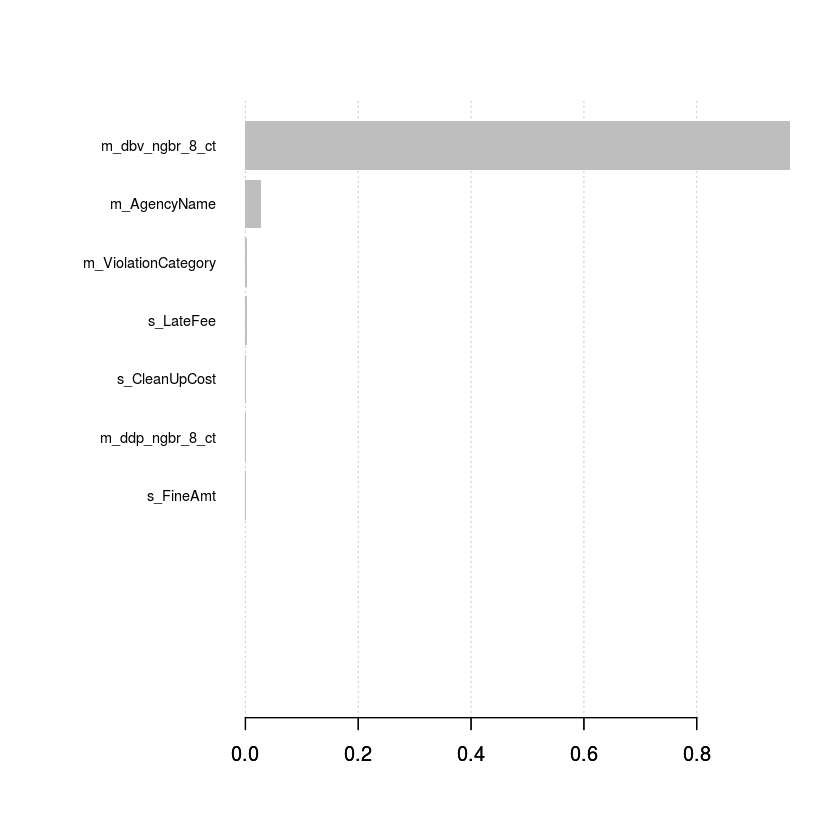

In [26]:
# Get the feature real names
names <- dimnames(trainMatrix)[[2]]

# Compute feature importance matrix
importance_matrix <- xgb.importance(names, model = xgb)

# Nice graph
xgb.plot.importance(importance_matrix[1:10,])

In [27]:
#library("xgboost")

xxKeep <- c("m_dbv_ngbr_8_ct","s_LateFee", "m_AgencyName","s_CleanUpCost","m_Demolished")
xxtrain <- train[xxKeep]
xxtest <- test[xxKeep]

xtrainMatrix <- as.matrix(xxtrain)
xtestMatrix <- as.matrix(xxtest)

xxgb <- xgboost(data = data.matrix(xxtrain[,-1]), 
 label =xxtrain$m_Demolished , 
 eta = 0.1,
 max_depth = 15, 
 nround=10, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "mlogloss",
 objective = "multi:softprob",
 num_class = 100,
 nthread = 2)



[1]	train-mlogloss:0.674368 
[2]	train-mlogloss:0.613699 
[3]	train-mlogloss:0.553222 
[4]	train-mlogloss:0.501072 
[5]	train-mlogloss:0.452855 
[6]	train-mlogloss:0.412001 
[7]	train-mlogloss:0.378653 
[8]	train-mlogloss:0.343457 
[9]	train-mlogloss:0.309428 
[10]	train-mlogloss:0.279168 


  [1] 0.775442123 0.004472221 0.002245668 0.002245749 0.002245667 0.002245832
  [7] 0.002245673 0.002246008 0.002245895 0.002245932 0.002245725 0.002245677
 [13] 0.002245785 0.002245716 0.002245885 0.002245754 0.002245791 0.002245734
 [19] 0.002246090 0.002245807 0.002245649 0.002245761 0.002245848 0.002245689
 [25] 0.002245763 0.002245516 0.002245722 0.002245688 0.002245339 0.002245719
 [31] 0.002245835 0.002245658 0.002245690 0.002245870 0.002245771 0.002245752
 [37] 0.002245890 0.002245724 0.002245789 0.002245836 0.002245898 0.002245598
 [43] 0.002245895 0.002245773 0.002245818 0.002245959 0.002245872 0.002245969
 [49] 0.002245658 0.002245696 0.002245895 0.002245834 0.002245571 0.002245776
 [55] 0.002246059 0.002245693 0.002245631 0.002245835 0.002245832 0.002245771
 [61] 0.002245696 0.002245893 0.002245635 0.002245698 0.002245810 0.002245601
 [67] 0.002246023 0.002245565 0.002245873 0.002245940 0.002245833 0.002245929
 [73] 0.002245790 0.002245928 0.002245933 0.002245675 0.00224568

##### xgb.Booster
raw: 185 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, eta = 0.1, max_depth = 15, subsample = 0.5, 
    colsample_bytree = 0.5, seed = 1, eval_metric = "mlogloss", 
    objective = "multi:softprob", num_class = 100, nthread = 2)
params (as set within xgb.train):
  eta = "0.1", max_depth = "15", subsample = "0.5", colsample_bytree = "0.5", seed = "1", eval_metric = "mlogloss", objective = "multi:softprob", num_class = "100", nthread = "2", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
  cb.save.model(save_period = save_period, save_name = save_name)
niter: 10
evaluation_log:
    iter train_mlogloss
       1       0.674368

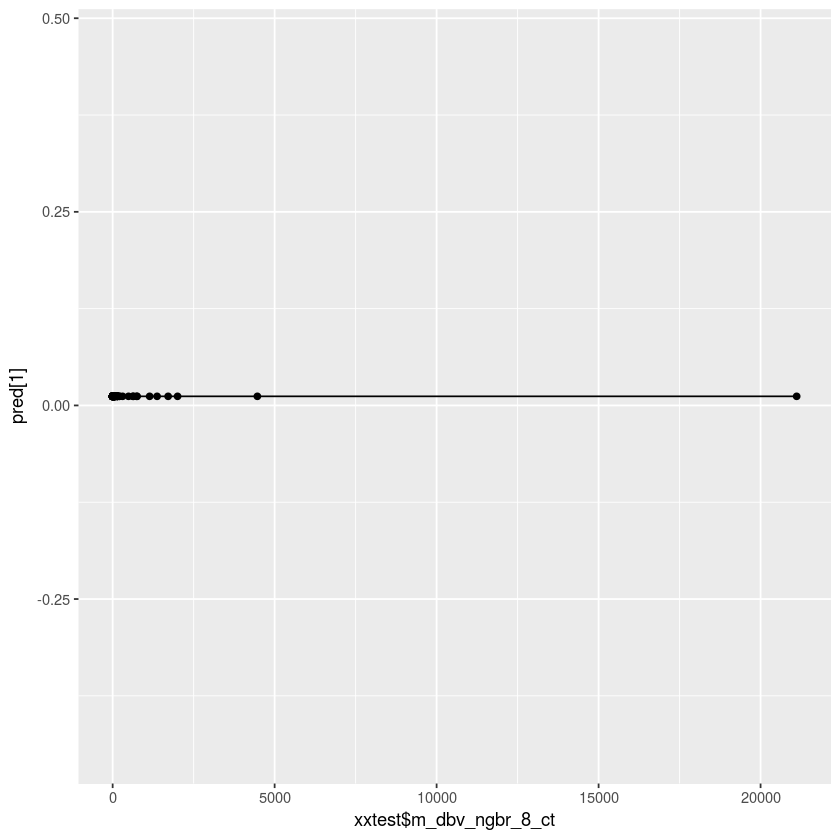

In [28]:
xpred <- predict(xxgb, t(xxtest[1,3]))

print(xpred)
ggplot(xxtest, aes(x=xxtest$m_dbv_ngbr_8_ct, y=pred[1])) +geom_point() + geom_line(data=xxtest, aes(y=pred[1]))
print(xxgb)

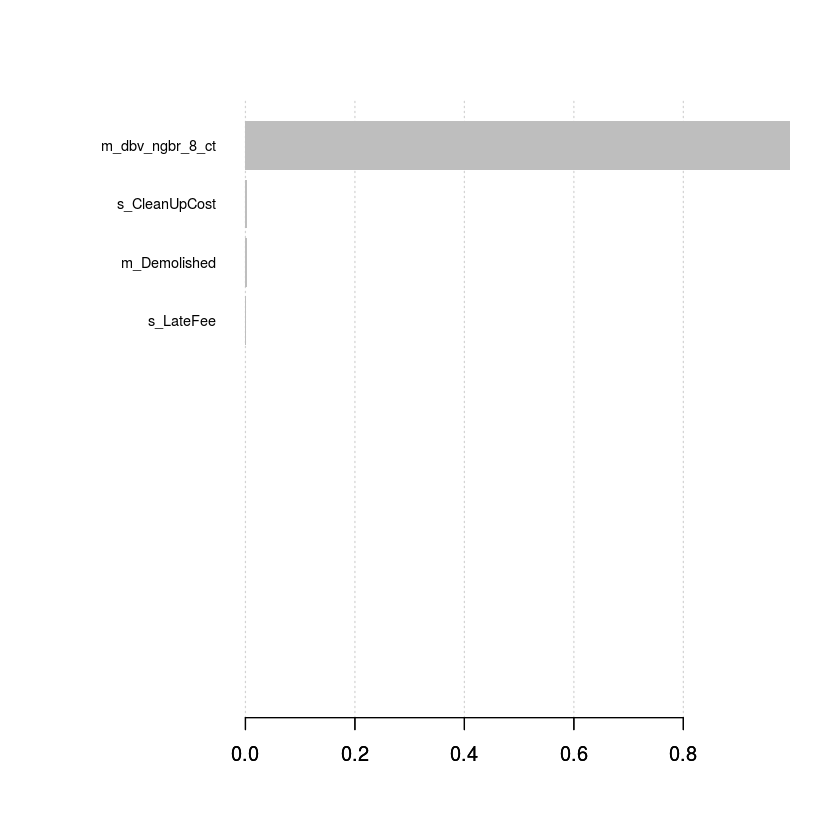

In [29]:
# Get the feature real names
names <- dimnames(xtrainMatrix)[[2]]

# Compute feature importance matrix
ximportance_matrix <- xgb.importance(names, model = xgb)

# Nice graph
xgb.plot.importance(ximportance_matrix[1:10,])